In [1]:
import queue, random, threading, math, time, pickle
import Adjustable_Snake as snake
import tensorflow as tf
import numpy as np
import tkinter as tkinter
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
# tf.debugging.set_log_device_placement(True)

save_path = "./save"
model_path = "./model"
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
stack_size = 2
game_size = 32

epsilon = 0.1
discount = 0.99
learning_rate = 0.001
c = 1000
learning_threshold = 25000

memory_size = 50000
batch_size = 64

In [3]:
def make_model():
    # Q-Network
    q = tf.keras.Sequential()

    input_size = (game_size, game_size, stack_size, 3)

    q.add(tf.keras.layers.Conv3D(game_size, (3, 3, 1),
                                activation="relu", input_shape=input_size))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    q.add(tf.keras.layers.Conv3D(game_size * 2, (3, 3, 1), activation="relu"))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    q.add(tf.keras.layers.Conv3D(game_size * 2, (3, 3, 1), activation="relu"))
    q.add(tf.keras.layers.MaxPooling3D((2, 2, 1)))

    q.add(tf.keras.layers.Flatten())

    q.add(tf.keras.layers.Dense(64, activation="relu"))
    q.add(tf.keras.layers.Dense(10, activation="relu"))
    q.add(tf.keras.layers.Dense(5))

    q.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss="mse")
    return q

In [4]:
try:
    q1 = tf.keras.models.load_model(save_path + "/model1")
    target_q = tf.keras.models.load_model(save_path + "/target_q")

    print("Loaded models")
except Exception as e:
    print(e)
    q1 = make_model()
    target_q = make_model()
    print("Created model")

q1.summary()
target_q.summary()

SavedModel file does not exist at: ./save/target_q/{saved_model.pbtxt|saved_model.pb}
Created model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 30, 2, 32)     896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 15, 2, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 13, 2, 64)     18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 2, 64)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 2, 64)       36928     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 2, 2, 64)       0         
______________________

In [5]:
try:
    with open(save_path + "/update_index.dat", "rb") as openfile:
        update_index = int(pickle.load(openfile))
    with open(save_path + "/filled_memory.dat", "rb") as openfile:
        filled_memory = int(pickle.load(openfile))
    with open(save_path + "/reset_steps.dat", "rb") as openfile:
        reset_steps = int(pickle.load(openfile))

    with open(save_path + "/states_memory.dat", "rb") as openfile:
        states_memory = pickle.load(openfile)
    with open(save_path + "/action_memory.dat", "rb") as openfile:
        action_memory = pickle.load(openfile)
    with open(save_path + "/reward_memory.dat", "rb") as openfile:
        reward_memory = pickle.load(openfile)
    with open(save_path + "/transitions_memory.dat", "rb") as openfile:
        transitions_memory = pickle.load(openfile)

    with open(save_path + "/scores.dat", "rb") as openfile:
        scores = pickle.load(openfile)
    with open(save_path + "/losses.dat", "rb") as openfile:
        losses = pickle.load(openfile)

    print("Loaded replay memory")
except Exception as e:
    print(e)
    update_index = 0
    filled_memory = 0
    reset_steps = 0

    # Replay Memory
    states_memory = np.ndarray((memory_size, game_size, game_size, stack_size, 3))
    action_memory = np.ndarray((memory_size))
    reward_memory = np.ndarray((memory_size))
    transitions_memory = np.ndarray((memory_size, game_size, game_size, stack_size, 3))

    scores = []
    losses = []
    
    print("Created replay memory")

Loaded replay memory


In [6]:
# class experience:
#     states = None
#     action = None
#     reward = None
#     transitions = None
    
#     def __init__(self, states, action, reward, transitions):
#         self.states = states
#         self.action = action
#         self.reward = reward
#         self.transitions = transitions

In [7]:
class agent:
    directions = ["UP", "DOWN", "LEFT", "RIGHT", "NONE"]

    def __init__(self, game):
        self.game = game
        self.phi = queue.deque()

        self.loss = []

    def update_memory(self, states, action, reward, transitions):
        global update_index, filled_memory
        if update_index >= memory_size:
            update_index = 0

        states_memory[update_index] = states
        action_memory[update_index] = action
        reward_memory[update_index] = reward
        transitions_memory[update_index] = transitions

        update_index += 1
        if filled_memory < memory_size:
            filled_memory += 1

    def stack(self, frames):

        fstack = np.stack(frames, axis=2)
        # fstack = frames[0]
        # for x in range(1, len(frames)):
        #     frame = np.expand_dims(frames[x], axis=2)
        #     print(fstack.shape)
        #     print(frame.shape)
        #     # frame = frames[x]
        #     fstack = np.stack((fstack, frame), axis=2)
            
        return fstack

    def epsilon_action(self):
        # print(len(self.phi))
        stack = np.expand_dims(self.stack(self.phi), axis=0)

        if random.uniform(0, 1) <= epsilon or not filled_memory > learning_threshold:
            prediction = [["n/a", "n/a", "n/a", "n/a", "n/a"]]

            action = self.directions[random.randint(0, 4)]
        else:
            prediction = q1.predict(stack)

            maxq = np.argmax(prediction)
            action = self.directions[maxq]
            # print(prediction)
            # print(action)
            # print(prediction[0][maxq])

        # print(action)
        return action, prediction

    def step(self):
        if len(self.phi) == 0:
            for x in range(stack_size):
                self.phi.append(self.game.get_state())

        action, values = self.epsilon_action()
        state_reward = self.game.step(action, values)

        phi_last = list(self.phi)
        self.phi.append(state_reward[0])

        if len(self.phi) > stack_size:
            phi_last = self.stack(phi_last)
            self.phi.popleft()
            phi_current = self.stack(self.phi)

            # if state_reward[1] != 0 or random.randint(0, 4) != 0:
            self.update_memory(phi_last, self.directions.index(action), state_reward[1], phi_current)

    def get_batch_indices(self, memory):
        indices = []
        for x in range(batch_size):
            indices.append(random.randint(0, filled_memory - 1))

        return indices

    def losses(self):
        yj_tensor = np.ndarray((batch_size))

        indices = self.get_batch_indices(states_memory)
        states = states_memory[indices]
        action = action_memory[indices]
        reward = reward_memory[indices]
        transitions = transitions_memory[indices]

        q_phi_next = target_q.predict(transitions)

        # Calculate expected values yj
        for t in range(batch_size):
            if reward[t] == -1:
                yj = reward[t]
            else:
                yj = reward[t] + (discount * np.amax(q_phi_next[t]))
                yj_tensor[t] = yj

        return states, yj_tensor
    def learn(self):
        global reset_steps, c

        if filled_memory > learning_threshold:
            states, expected_data = self.losses()

            # before1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            # before2 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            # before1 = q1.get_weights()[0][0]
            # before2 = q2.get_weights()[0][0]

            q1.train_on_batch(states, expected_data)

            # gradient = tape.gradient()
            # optimizer.apply_gradients(zip(self.grad(), model.trainable_variables))
            # gradient = optimizer.get_gradients(losses, q.trainable_variables)
            # optimizer.apply_gradients(gradient)

            after1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            # after2 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            # # # after1 = q1.get_weights()[0][0]
            # # # after2 = q2.get_weights()[0][0]

            # difference = after1 - before1

            # print("Before: " + str(before1))
            # print("After:  " + str(after1))
            # print("Difference: " + str(difference))
            # print()

            if math.isnan(after1[0][0]):
                print("NaN")
            if math.isinf(after1[0][0]):
                print("inf")

            reset_steps += 1
            if reset_steps >= c:
                reset_steps = 0
                target_q.set_weights(q1.get_weights())

            self.loss.append(np.abs(np.average(expected_data) - np.average(q1.predict(states))))
        else:
            self.loss.append(0)

In [8]:
def plot():
    # print("==============================")
    # print("AVERAGE LOSS v. FRAME")
    # plt.plot(average_loss)
    # plt.xlabel("Frame")
    # plt.ylabel("Average Loss")
    # plt.show()
    # print("==============================")
    print("SCORE v. EPISODE")
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()
    print("AVERAGE LOSS v. EPISODE")
    plt.plot(losses)
    plt.xlabel("Episode")
    plt.ylabel("Average Loss")
    plt.show()
    print("==============================")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


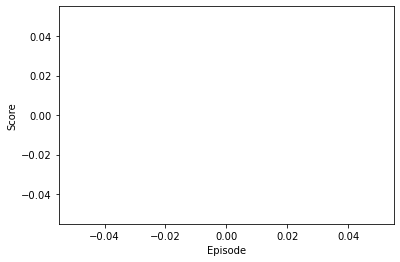

AVERAGE LOSS v. EPISODE


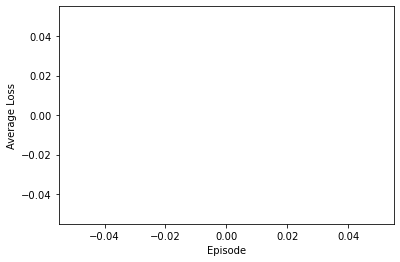

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


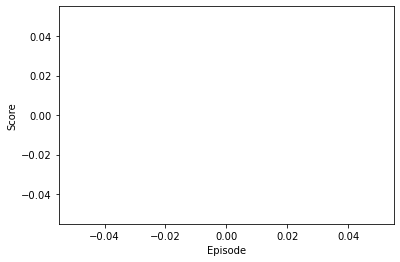

AVERAGE LOSS v. EPISODE


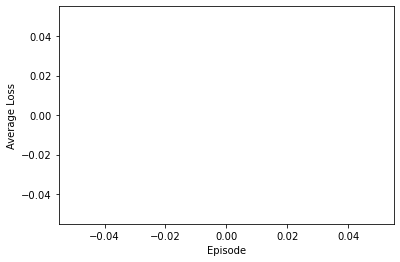

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


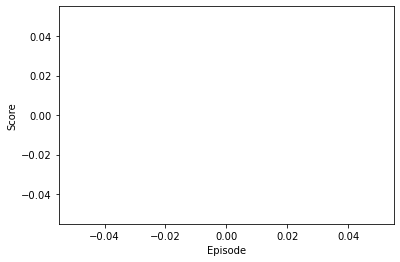

AVERAGE LOSS v. EPISODE


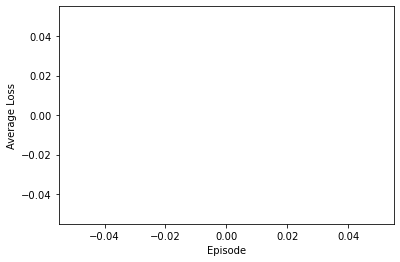

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


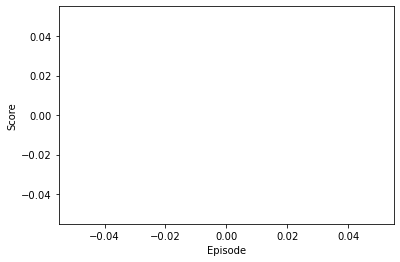

AVERAGE LOSS v. EPISODE


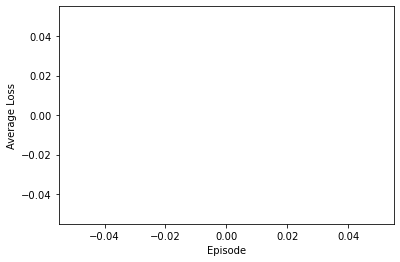

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


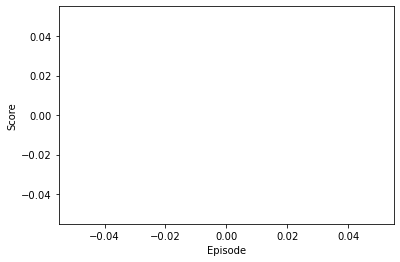

AVERAGE LOSS v. EPISODE


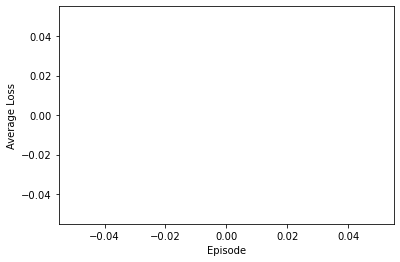

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


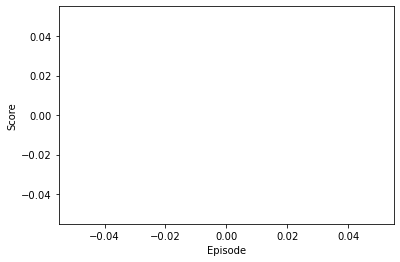

AVERAGE LOSS v. EPISODE


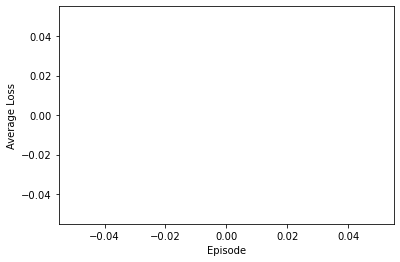

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./model1\assets
SCORE v. EPISODE


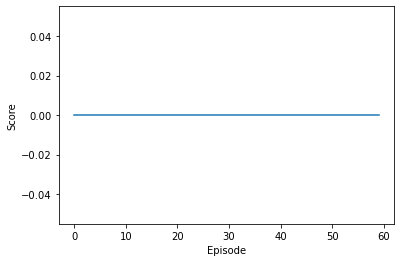

AVERAGE LOSS v. EPISODE


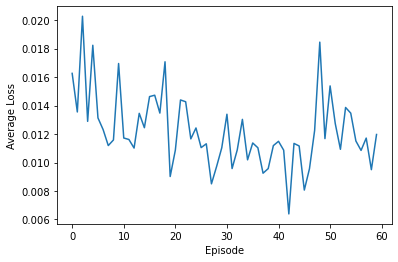

In [9]:
game = snake.game()
x = 0

while True:
    # print("Training agent on episode " + str(x))
    dqn = agent(game)

    game.start(dqn)

    if x % 100 == 0:
        q1.save(save_path + "/model1", overwrite=True, include_optimizer=True)
        q1.save(model_path + "1", overwrite=True, include_optimizer=True)

    if x % 100 == 0:
        with open(save_path + "/update_index.dat", "wb") as openfile:
            pickle.dump(update_index, openfile)
        with open(save_path + "/filled_memory.dat", "wb") as openfile:
            pickle.dump(filled_memory, openfile)
        with open(save_path + "/reset_steps.dat", "wb") as openfile:
            pickle.dump(reset_steps, openfile)

        with open(save_path + "/states_memory.dat", "wb") as openfile:
            pickle.dump(states_memory, openfile, protocol=4)
        with open(save_path + "/action_memory.dat", "wb") as openfile:
            pickle.dump(action_memory, openfile)
        with open(save_path + "/reward_memory.dat", "wb") as openfile:
            pickle.dump(reward_memory, openfile)
        with open(save_path + "/transitions_memory.dat", "wb") as openfile:
            pickle.dump(transitions_memory, openfile, protocol=4)

        with open(save_path + "/scores.dat", "wb") as openfile:
            pickle.dump(scores, openfile)
        with open(save_path + "/losses.dat", "wb") as openfile:
            pickle.dump(losses, openfile)

        plot()
    x += 1

    # print("Finished episode " + str(x) + ", agent scored " + str(game.score) + " points.")
    if filled_memory > learning_threshold:
        scores.append(game.score)
        losses.append(sum(dqn.loss) / len(dqn.loss))